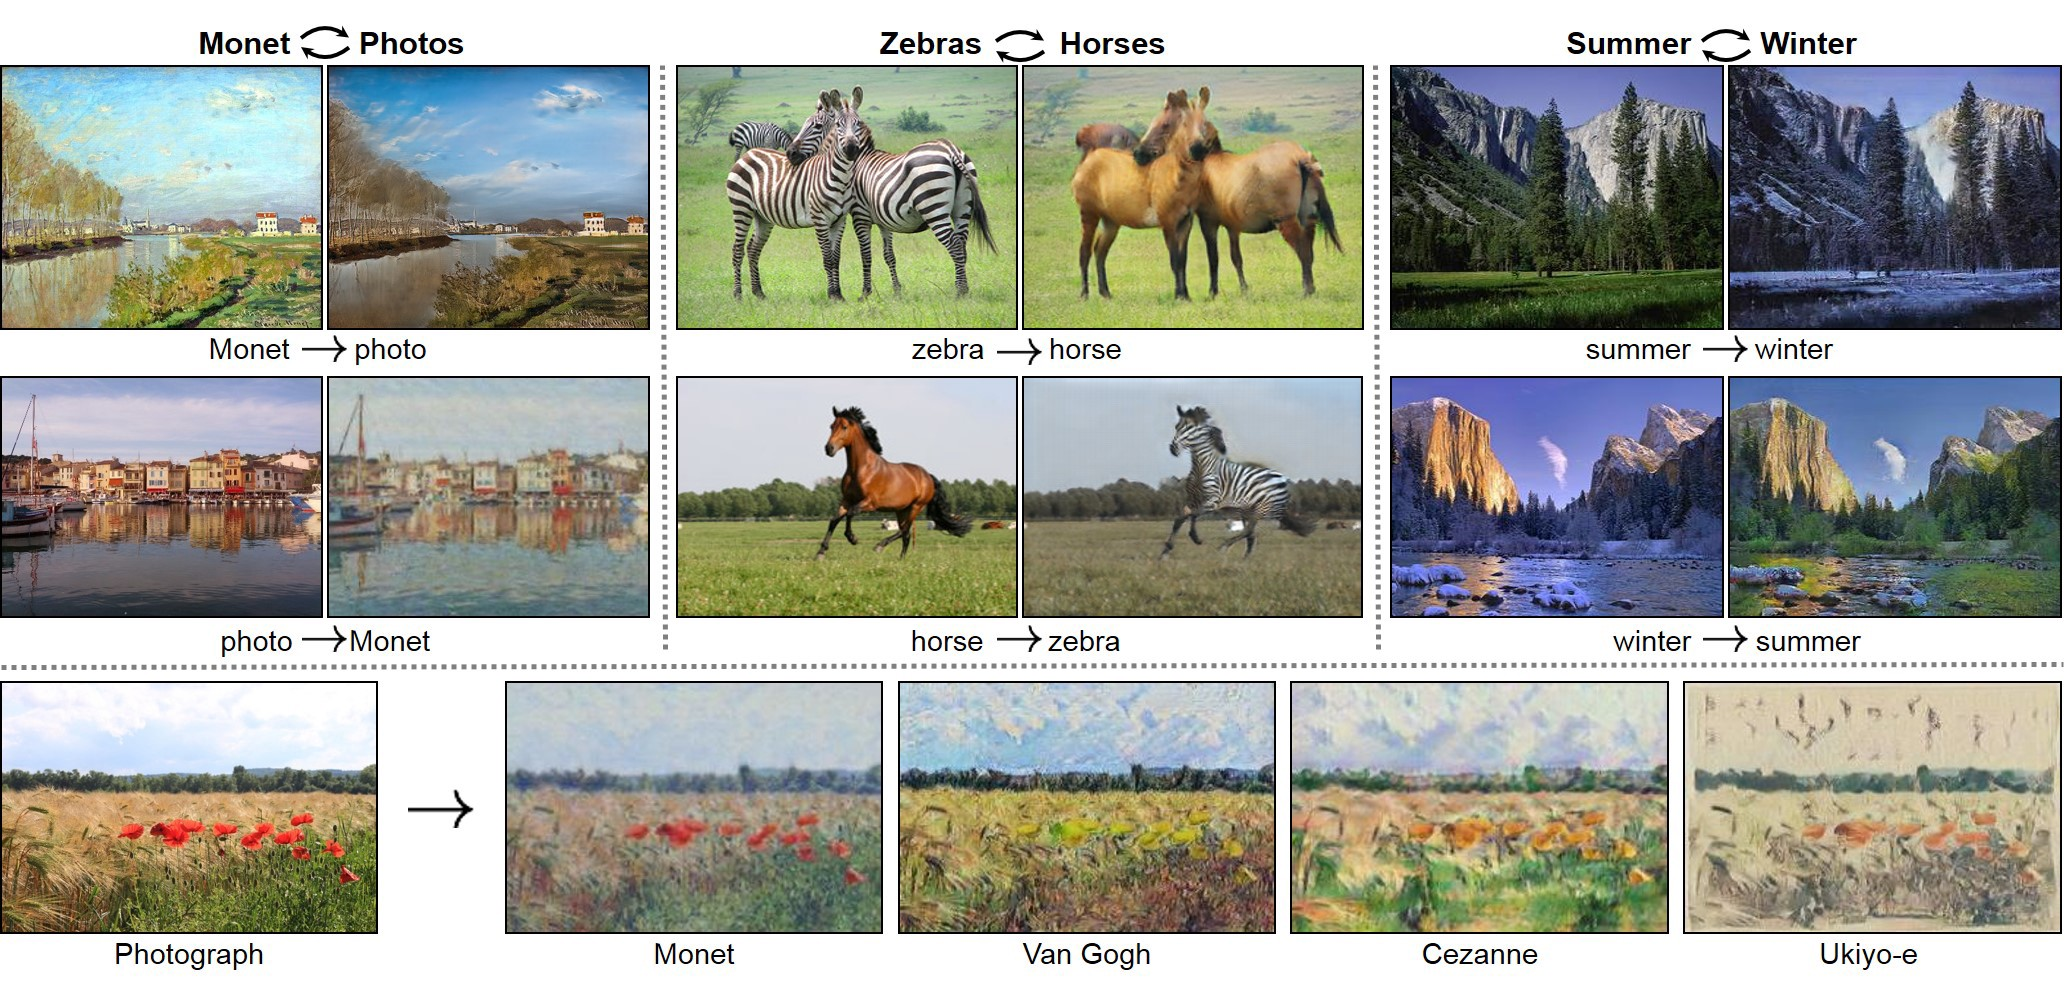

CycleGan is used to Image to Image Translation using unpaired images i.e source and target objects images not need to be of same size/shape, you can collect random source/target images collection and expect cyclegan to work. One other model is [UGATIT](https://github.com/znxlwm/UGATIT-pytorch) which is also Unpaired image-image translation gan model.

## Imports

In [ ]:
!pip install tfa-nightly -qq

In [ ]:
import tensorflow as tf
import numpy as np
import os, functools
import cv2
import tensorflow_datasets as tfds
import tensorflow_addons as tfa
import tensorflow.keras as keras
import matplotlib.pyplot as plt

## Args/Config

In [ ]:
class Config():
  image_size = 256 # image size
  batch_size = 2
  epochs = 50 # original 200
  epoch_decay = 100 # epoch to start decaying learning rate
  lr = 0.0002
  beta_1 = 0.5
  adversarial_loss_mode = 'lsgan' # ['gan', 'hinge_v1', 'hinge_v2', 'lsgan', 'wgan']
  gradient_penalty_mode = 'none' # ['none', 'dragan', 'wgan-gp']
  gradient_penalty_weight = 10.0
  cycle_loss_weight = 10.0
  identity_loss_weight = 0.0
  pool_size = 50 # pool size to store fake samples
  output_dir = '/content/'
  print_freq = 50

args = Config()

## Dataloader

In [ ]:
class ItemPool:

    def __init__(self, pool_size=50):
        self.pool_size = pool_size
        self.items = []

    def __call__(self, in_items):
        # `in_items` should be a batch tensor

        if self.pool_size == 0:
            return in_items

        out_items = []
        for in_item in in_items:
            if len(self.items) < self.pool_size:
                self.items.append(in_item)
                out_items.append(in_item)
            else:
                if np.random.rand() > 0.5:
                    idx = np.random.randint(0, len(self.items))
                    out_item, self.items[idx] = self.items[idx], in_item
                    out_items.append(out_item)
                else:
                    out_items.append(in_item)
        return tf.stack(out_items, axis=0)

In [ ]:
def train_preprocessing(image,label, image_size=args.image_size):
  # img = tf.image.resize(img, [load_size, load_size]) # resize image to a base size
  image = tf.image.random_crop(image, [image_size, image_size, tf.shape(image)[-1]])
  image = tf.cast(image, tf.float32) / 255.0 # or img = tl.minmax_norm(img)
  # img = img * 2 - 1
  return image, label

def test_preprocessing(image,label, image_size=args.image_size):
  image = tf.image.resize(image, [image_size, image_size])
  image = tf.cast(image, tf.float32) / 255.0
  return image, label

In [ ]:
# load dataset

dataset, metadata = tfds.load('cycle_gan/summer2winter_yosemite', with_info=True, as_supervised=True)
A_dataset, B_dataset = dataset['trainA'], dataset['trainB']
A_dataset = A_dataset.map(train_preprocessing)
B_dataset = B_dataset.map(train_preprocessing)
A_dataset = A_dataset.batch(args.batch_size)
B_dataset = B_dataset.batch(args.batch_size)
A_B_dataset, len_dataset = tf.data.Dataset.zip((A_dataset, B_dataset)), max(len(A_dataset), len(B_dataset)) // args.batch_size

A2B_pool = ItemPool(args.pool_size)
B2A_pool = ItemPool(args.pool_size)

A_dataset_test, B_dataset_test = dataset['testA'], dataset['testB']
A_dataset_test = A_dataset_test.map(test_preprocessing)
B_dataset_test = B_dataset_test.map(test_preprocessing)
A_dataset_test = A_dataset_test.batch(args.batch_size)
B_dataset_test = B_dataset_test.batch(args.batch_size)
A_B_dataset_test, len_dataset_test = tf.data.Dataset.zip((A_dataset_test, B_dataset_test)), max(len(A_dataset_test), len(B_dataset_test)) // args.batch_size

## Loss functions

In [ ]:
def get_gan_losses_fn():
    bce = tf.losses.BinaryCrossentropy(from_logits=True)

    def d_loss_fn(r_logit, f_logit):
        r_loss = bce(tf.ones_like(r_logit), r_logit)
        f_loss = bce(tf.zeros_like(f_logit), f_logit)
        return r_loss, f_loss

    def g_loss_fn(f_logit):
        f_loss = bce(tf.ones_like(f_logit), f_logit)
        return f_loss

    return d_loss_fn, g_loss_fn


def get_hinge_v1_losses_fn():
    def d_loss_fn(r_logit, f_logit):
        r_loss = tf.reduce_mean(tf.maximum(1 - r_logit, 0))
        f_loss = tf.reduce_mean(tf.maximum(1 + f_logit, 0))
        return r_loss, f_loss

    def g_loss_fn(f_logit):
        f_loss = tf.reduce_mean(tf.maximum(1 - f_logit, 0))
        return f_loss

    return d_loss_fn, g_loss_fn


def get_hinge_v2_losses_fn():
    def d_loss_fn(r_logit, f_logit):
        r_loss = tf.reduce_mean(tf.maximum(1 - r_logit, 0))
        f_loss = tf.reduce_mean(tf.maximum(1 + f_logit, 0))
        return r_loss, f_loss

    def g_loss_fn(f_logit):
        f_loss = tf.reduce_mean(- f_logit)
        return f_loss

    return d_loss_fn, g_loss_fn


def get_lsgan_losses_fn():
    mse = tf.losses.MeanSquaredError()

    def d_loss_fn(r_logit, f_logit):
        r_loss = mse(tf.ones_like(r_logit), r_logit)
        f_loss = mse(tf.zeros_like(f_logit), f_logit)
        return r_loss, f_loss

    def g_loss_fn(f_logit):
        f_loss = mse(tf.ones_like(f_logit), f_logit)
        return f_loss

    return d_loss_fn, g_loss_fn


def get_wgan_losses_fn():
    def d_loss_fn(r_logit, f_logit):
        r_loss = - tf.reduce_mean(r_logit)
        f_loss = tf.reduce_mean(f_logit)
        return r_loss, f_loss

    def g_loss_fn(f_logit):
        f_loss = - tf.reduce_mean(f_logit)
        return f_loss

    return d_loss_fn, g_loss_fn


def get_adversarial_losses_fn(mode):
    if mode == 'gan':
        return get_gan_losses_fn()
    elif mode == 'hinge_v1':
        return get_hinge_v1_losses_fn()
    elif mode == 'hinge_v2':
        return get_hinge_v2_losses_fn()
    elif mode == 'lsgan':
        return get_lsgan_losses_fn()
    elif mode == 'wgan':
        return get_wgan_losses_fn()


def gradient_penalty(f, real, fake, mode):
    def _gradient_penalty(f, real, fake=None):
        def _interpolate(a, b=None):
            if b is None:   # interpolation in DRAGAN
                beta = tf.random.uniform(shape=tf.shape(a), minval=0., maxval=1.)
                b = a + 0.5 * tf.math.reduce_std(a) * beta
            shape = [tf.shape(a)[0]] + [1] * (a.shape.ndims - 1)
            alpha = tf.random.uniform(shape=shape, minval=0., maxval=1.)
            inter = a + alpha * (b - a)
            inter.set_shape(a.shape)
            return inter

        x = _interpolate(real, fake)
        with tf.GradientTape() as t:
            t.watch(x)
            pred = f(x)
        grad = t.gradient(pred, x)
        norm = tf.norm(tf.reshape(grad, [tf.shape(grad)[0], -1]), axis=1)
        gp = tf.reduce_mean((norm - 1.)**2)

        return gp

    if mode == 'none':
        gp = tf.constant(0, dtype=real.dtype)
    elif mode == 'dragan':
        gp = _gradient_penalty(f, real)
    elif mode == 'wgan-gp':
        gp = _gradient_penalty(f, real, fake)

    return gp

## LR scheduler            

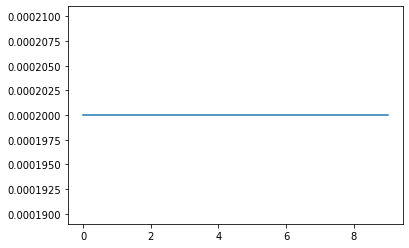

In [ ]:
class LinearDecay(keras.optimizers.schedules.LearningRateSchedule):
    # if `step` < `step_decay`: use fixed learning rate
    # else: linearly decay the learning rate to zero

    def __init__(self, initial_learning_rate, total_steps, step_decay):
        super(LinearDecay, self).__init__()
        self._initial_learning_rate = initial_learning_rate
        self._steps = total_steps
        self._step_decay = step_decay
        self.current_learning_rate = tf.Variable(initial_value=initial_learning_rate, trainable=False, dtype=tf.float32)

    def __call__(self, step):
        self.current_learning_rate.assign(tf.cond(
            step >= self._step_decay,
            true_fn=lambda: self._initial_learning_rate * (1 - 1 / (self._steps - self._step_decay) * (step - self._step_decay)),
            false_fn=lambda: self._initial_learning_rate
        ))
        return self.current_learning_rate

lrfn = LinearDecay(args.lr, args.epochs * len_dataset, args.epoch_decay * len_dataset)
rng = [i for i in range(args.epochs)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
plt.show()
# print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))        

## Model

In [ ]:
def _get_norm_layer(norm):
    if norm == 'none':
        return lambda: lambda x: x
    elif norm == 'batch_norm':
        return keras.layers.BatchNormalization
    elif norm == 'instance_norm':
        return tfa.layers.InstanceNormalization
    elif norm == 'layer_norm':
        return keras.layers.LayerNormalization

def ResnetGenerator(input_shape=(256, 256, 3),
                    output_channels=3,
                    dim=64,
                    n_downsamplings=2,
                    n_blocks=9,
                    norm='instance_norm'):
    Norm = _get_norm_layer(norm)

    def _residual_block(x):
        dim = x.shape[-1]
        h = x

        h = tf.pad(h, [[0, 0], [1, 1], [1, 1], [0, 0]], mode='REFLECT')
        h = keras.layers.Conv2D(dim, 3, padding='valid', use_bias=False)(h)
        h = Norm()(h)
        h = tf.nn.relu(h)

        h = tf.pad(h, [[0, 0], [1, 1], [1, 1], [0, 0]], mode='REFLECT')
        h = keras.layers.Conv2D(dim, 3, padding='valid', use_bias=False)(h)
        h = Norm()(h)

        return keras.layers.add([x, h])

    # 0
    h = inputs = keras.Input(shape=input_shape)

    # 1
    h = tf.pad(h, [[0, 0], [3, 3], [3, 3], [0, 0]], mode='REFLECT')
    h = keras.layers.Conv2D(dim, 7, padding='valid', use_bias=False)(h)
    h = Norm()(h)
    h = tf.nn.relu(h)

    # 2
    for _ in range(n_downsamplings):
        dim *= 2
        h = keras.layers.Conv2D(dim, 3, strides=2, padding='same', use_bias=False)(h)
        h = Norm()(h)
        h = tf.nn.relu(h)

    # 3
    for _ in range(n_blocks):
        h = _residual_block(h)

    # 4
    for _ in range(n_downsamplings):
        dim //= 2
        h = keras.layers.Conv2DTranspose(dim, 3, strides=2, padding='same', use_bias=False)(h)
        h = Norm()(h)
        h = tf.nn.relu(h)

    # 5
    h = tf.pad(h, [[0, 0], [3, 3], [3, 3], [0, 0]], mode='REFLECT')
    h = keras.layers.Conv2D(output_channels, 7, padding='valid')(h)
    h = tf.tanh(h)

    return keras.Model(inputs=inputs, outputs=h)


def ConvDiscriminator(input_shape=(256, 256, 3),
                      dim=64,
                      n_downsamplings=3,
                      norm='instance_norm'):
    dim_ = dim
    Norm = _get_norm_layer(norm)

    # 0
    h = inputs = keras.Input(shape=input_shape)

    # 1
    h = keras.layers.Conv2D(dim, 4, strides=2, padding='same')(h)
    h = tf.nn.leaky_relu(h, alpha=0.2)

    for _ in range(n_downsamplings - 1):
        dim = min(dim * 2, dim_ * 8)
        h = keras.layers.Conv2D(dim, 4, strides=2, padding='same', use_bias=False)(h)
        h = Norm()(h)
        h = tf.nn.leaky_relu(h, alpha=0.2)

    # 2
    dim = min(dim * 2, dim_ * 8)
    h = keras.layers.Conv2D(dim, 4, strides=1, padding='same', use_bias=False)(h)
    h = Norm()(h)
    h = tf.nn.leaky_relu(h, alpha=0.2)

    # 3
    h = keras.layers.Conv2D(1, 4, strides=1, padding='same')(h)

    return keras.Model(inputs=inputs, outputs=h)

In [ ]:
G_A2B = ResnetGenerator(input_shape=(args.image_size, args.image_size, 3))
G_B2A = ResnetGenerator(input_shape=(args.image_size, args.image_size, 3))

D_A = ConvDiscriminator(input_shape=(args.image_size, args.image_size, 3))
D_B = ConvDiscriminator(input_shape=(args.image_size, args.image_size, 3))

d_loss_fn, g_loss_fn = get_adversarial_losses_fn(args.adversarial_loss_mode)
cycle_loss_fn = tf.losses.MeanAbsoluteError()
identity_loss_fn = tf.losses.MeanAbsoluteError()

G_lr_scheduler = LinearDecay(args.lr, args.epochs * len_dataset, args.epoch_decay * len_dataset)
D_lr_scheduler = LinearDecay(args.lr, args.epochs * len_dataset, args.epoch_decay * len_dataset)
G_optimizer = keras.optimizers.Adam(learning_rate=G_lr_scheduler, beta_1=args.beta_1)
D_optimizer = keras.optimizers.Adam(learning_rate=D_lr_scheduler, beta_1=args.beta_1)

## Some functions

In [ ]:
def save_image(images, save_path):

  for img in images:
    img = img*255.0
    img = img.astype(np.uint8)

  images = [Image.fromarray(x) for x in images]
  widths, heights = zip(*(i.size for i in images))

  total_width = sum(widths)
  max_height = max(heights)

  new_im = Image.new('RGB', (total_width, max_height))

  x_offset = 0
  for im in images:
    new_im.paste(im, (x_offset,0))
    x_offset += im.size[0]

  new_im.save(save_path)

def check_dir(p):
  if os.path.isdir(p):
    pass
  else:  
    os.mkdir(p)

## Trainer function

In [ ]:
@tf.function
def train_G(A, B):
    with tf.GradientTape() as t:
        A2B = G_A2B(A, training=True)
        B2A = G_B2A(B, training=True)
        A2B2A = G_B2A(A2B, training=True)
        B2A2B = G_A2B(B2A, training=True)
        A2A = G_B2A(A, training=True)
        B2B = G_A2B(B, training=True)

        A2B_d_logits = D_B(A2B, training=True)
        B2A_d_logits = D_A(B2A, training=True)

        A2B_g_loss = g_loss_fn(A2B_d_logits)
        B2A_g_loss = g_loss_fn(B2A_d_logits)
        A2B2A_cycle_loss = cycle_loss_fn(A, A2B2A)
        B2A2B_cycle_loss = cycle_loss_fn(B, B2A2B)
        A2A_id_loss = identity_loss_fn(A, A2A)
        B2B_id_loss = identity_loss_fn(B, B2B)

        G_loss = (A2B_g_loss + B2A_g_loss) + (A2B2A_cycle_loss + B2A2B_cycle_loss) * args.cycle_loss_weight + (A2A_id_loss + B2B_id_loss) * args.identity_loss_weight

    G_grad = t.gradient(G_loss, G_A2B.trainable_variables + G_B2A.trainable_variables)
    G_optimizer.apply_gradients(zip(G_grad, G_A2B.trainable_variables + G_B2A.trainable_variables))

    return A2B, B2A, {'A2B_g_loss': A2B_g_loss,
                      'B2A_g_loss': B2A_g_loss,
                      'A2B2A_cycle_loss': A2B2A_cycle_loss,
                      'B2A2B_cycle_loss': B2A2B_cycle_loss,
                      'A2A_id_loss': A2A_id_loss,
                      'B2B_id_loss': B2B_id_loss}


@tf.function
def train_D(A, B, A2B, B2A):
    with tf.GradientTape() as t:
        A_d_logits = D_A(A, training=True)
        B2A_d_logits = D_A(B2A, training=True)
        B_d_logits = D_B(B, training=True)
        A2B_d_logits = D_B(A2B, training=True)

        A_d_loss, B2A_d_loss = d_loss_fn(A_d_logits, B2A_d_logits)
        B_d_loss, A2B_d_loss = d_loss_fn(B_d_logits, A2B_d_logits)
        D_A_gp = gradient_penalty(functools.partial(D_A, training=True), A, B2A, mode=args.gradient_penalty_mode)
        D_B_gp = gradient_penalty(functools.partial(D_B, training=True), B, A2B, mode=args.gradient_penalty_mode)

        D_loss = (A_d_loss + B2A_d_loss) + (B_d_loss + A2B_d_loss) + (D_A_gp + D_B_gp) * args.gradient_penalty_weight

    D_grad = t.gradient(D_loss, D_A.trainable_variables + D_B.trainable_variables)
    D_optimizer.apply_gradients(zip(D_grad, D_A.trainable_variables + D_B.trainable_variables))

    return {'A_d_loss': A_d_loss + B2A_d_loss,
            'B_d_loss': B_d_loss + A2B_d_loss,
            'D_A_gp': D_A_gp,
            'D_B_gp': D_B_gp}


def train_step(A, B):
    A2B, B2A, G_loss_dict = train_G(A, B)

    # cannot autograph `A2B_pool`
    A2B = A2B_pool(A2B)  # or A2B = A2B_pool(A2B.numpy()), but it is much slower
    B2A = B2A_pool(B2A)  # because of the communication between CPU and GPU

    D_loss_dict = train_D(A, B, A2B, B2A)

    return G_loss_dict, D_loss_dict


@tf.function
def sample(A, B):
    A2B = G_A2B(A, training=False)
    B2A = G_B2A(B, training=False)
    A2B2A = G_B2A(A2B, training=False)
    B2A2B = G_A2B(B2A, training=False)
    return A2B, B2A, A2B2A, B2A2B

## Trainer

In [ ]:
tf.config.run_functions_eagerly(True)

In [ ]:
# epoch counter
ep_cnt = tf.Variable(initial_value=1, trainable=False, dtype=tf.int64)

# checkpoint
checkpoint_path = "./checkpoints/train"
checkpoint = tf.train.Checkpoint(G_A2B=G_A2B,
                                G_B2A=G_B2A,
                                D_A=D_A,
                                D_B=D_B,
                                G_optimizer=G_optimizer,
                                D_optimizer=D_optimizer,
                                ep_cnt=ep_cnt)

ckpt_manager = tf.train.CheckpointManager(checkpoint, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  checkpoint.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

# sample
test_iter = iter(A_B_dataset_test)
sample_dir = os.path.join(args.output_dir, 'samples_training')
check_dir(sample_dir)

# main loop

for epoch in range(1, args.epochs+1):
  print("Epoch:",epoch)
  if epoch < ep_cnt:
      continue

  # update epoch counter
  ep_cnt.assign_add(1)

  G_loss = 0.0
  D_loss = 0.0
  # train for an epoch
  for step, (A, B) in enumerate(A_B_dataset):
      G_loss_dict, D_loss_dict = train_step(A[0], B[0])
      if step % args.print_freq == 0:
        print('.', end='')
        # A, B = next(test_iter)
        # A2B, B2A, A2B2A, B2A2B = sample(A[0], B[0])

  # save checkpoint
  ckpt_save_path = ckpt_manager.save()
  print('')

Latest checkpoint restored!!
Epoch: 1
Epoch: 2


## Tester

In [ ]:
checkpoint_path = "./checkpoints/train"
checkpoint = tf.train.Checkpoint(G_A2B=G_A2B,
                                G_B2A=G_B2A,
                                D_A=D_A,
                                D_B=D_B,
                                G_optimizer=G_optimizer,
                                D_optimizer=D_optimizer,
                                ep_cnt=ep_cnt)

ckpt_manager = tf.train.CheckpointManager(checkpoint, checkpoint_path, max_to_keep=5)

# restore checkpoint
if ckpt_manager.latest_checkpoint:
  checkpoint.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

@tf.function
def sample_A2B(A):
    A2B = G_A2B(A, training=False)
    A2B2A = G_B2A(A2B, training=False)
    return A2B, A2B2A

@tf.function
def sample_B2A(B):
    B2A = G_B2A(B, training=False)
    B2A2B = G_A2B(B2A, training=False)
    return B2A, B2A2B

# run
save_dir = os.path.join(args.output_dir, 'samples_output', 'A2B')
check_dir(save_dir)

i = 0
for A in A_dataset_test:
    A2B, A2B2A = sample_A2B(A)
    for A_i, A2B_i, A2B2A_i in zip(A, A2B, A2B2A):
        img = save_image([A_i.numpy(), A2B_i.numpy(), A2B2A_i.numpy()], os.path.join(save_dir, f'image{i}.jpg'))
        i += 1

save_dir = os.path.join(args.output_dir, 'samples_output', 'B2A')
check_dir(save_dir)
  
i = 0
for B in B_dataset_test:
    B2A, B2A2B = sample_B2A(B)
    for B_i, B2A_i, B2A2B_i in zip(B, B2A, B2A2B):
        img = save_image([B_i.numpy(), B2A_i.numpy(), B2A2B_i.numpy()], os.path.join(save_dir, f'image{i}.jpg'))
        i += 1

Reference: </br>
cycleGan implementation https://github.com/LynnHo/CycleGAN-Tensorflow-2 </br>
Official tf blog https://www.tensorflow.org/tutorials/generative/cyclegan